In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc; gc.collect()
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [3]:
train_df_path="../input/hpa-cell-tiles-sample-balanced-dataset/cell_df.csv"
train_images_path="../input/hpa-cell-tiles-sample-balanced-dataset/cells"

In [4]:
train_df=pd.read_csv(train_df_path)
train_df = train_df.rename(columns = {'image_labels': 'Label'}, inplace = False)
train_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


In [5]:
train_df.Label.unique()

array(['0', '1|0', '5|1|13', '6|1', '1|2|0', '12|1|0', '1|2', '1',
       '16|1|13', '1|0|13', '14|1|0', '12|1|2', '16|1|0', '9|1|13',
       '16|1', '1|4', '16|1|2', '16|7|1|0', '12|5|1|0', '7|1|2|0', '10|1',
       '9|1|0', '7|1', '14|1', '7|1|0|13', '1|3', '1|13', '5|1', '12|1',
       '8|1|0', '1|2|13', '1|3|0|13', '8|1', '14|1|2|0', '1|3|0', '7|1|0',
       '9|1|2|0', '16|5|1', '13|1', '5|1|0', '10|1|0', '16|1|4', '2', '3',
       '4', '5', '6', '16|6', '6|14', '6|13', '16|6|0', '16|6|2', '6|2',
       '6|0', '6|3', '12|6', '6|5', '16|6|13', '6|7', '16|6|3|0', '6|2|0',
       '6|9', '6|5|0', '16|6|2|0', '6|17', '9|6|13', '6|10|2', '6|4',
       '9|6', '7', '8', '9', '9|9', '9|13', '16|9|13', '16|9|2|0', '9|0',
       '13|16|9|4|13', '13|16|9|13', '9|16|13', '9|14|0', '9|16',
       '12|9|0', '16|9', '9|12|16', '9|5|0|17', '16|9|0', '9|4',
       '12|16|9', '9|9|13', '9|16|0', '9|3', '9|17', '9|0|13', '9|5',
       '9|12', '9|7|0', '9|16|0|13', '9|2|0', '13|9|13', '16|9|7|0',
     

In [6]:
train=train_df['Label'].apply(lambda x:[max(list(map(int,x.split('|'))))<10])
train.tolist()
flat_list = [item for sublist in train for item in sublist]
train=train_df.iloc[flat_list]
train.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


In [7]:
train['ID']=train['image_id']+ '_'+ (train['cell_id']).astype(str) 
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5


In [8]:
index=train['Label'].apply(lambda x:[len(list(map(int,x.split('|'))))<2])
index.tolist()
flat_list = [item for sublist in index for item in sublist]
train=train.iloc[flat_list]
train.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5


In [9]:
train.Label.unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [10]:
df=train
df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import time

def visualize2DSoftmax(X, y, model):
    """Function to visualize the classification boundary of a learned model on a 2-D dataset

    Arguments:
    X -- a numpy array of shape (2, N), where N is the number of data points. 
    y -- a numpy array of shape (N,), which contains values of either "0" or "1" for two different classes
    model -- a PyTorch Module object that represents a classifer to visualize. s
    """
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        preds = model(torch.tensor(xy_v, dtype=torch.float32))
        preds = F.softmax(preds, dim=1).numpy()

    cs = plt.contourf(xv, yv, preds[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=cs.ax)

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        # print("labels",labels)
        

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # print("output",y_hat)
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape) 
    
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
        
    def forward(self, x):
        return self.lambd(x)
    
class DebugShape(nn.Module):
    """
    Module that is useful to help debug your neural network architecture. 
    Insert this module between layers and it will print out the shape of 
    that layer. 
    """
    def forward(self, input):
        print(input.shape)
        return input
    
def weight_reset(m):
    """
    Go through a PyTorch module m and reset all the weights to an initial random state
    """
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj
        
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            if isinstance(labels, torch.Tensor):
                batch_size = labels.shape[0]
            elif isinstance(inputs, torch.Tensor):
                batch_size = inputs.shape[0]
            else:
                batch_size = len(inputs)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            try:
                results["train " + name].append( score_func(y_true, y_pred) )
            except:
                results["train " + name].append("NaN")
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if isinstance(labels, torch.Tensor):
                    batch_size = labels.shape[0]
                elif isinstance(inputs, torch.Tensor):
                    batch_size = inputs.shape[0]
                else:
                    batch_size = len(inputs)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                try:
                    results["val " + name].append( score_func(y_true, y_pred) )
                except:
                    results["val " + name].append( "NaN" )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

### RNN utility Classes 

class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tyuple (out, (h_t, c_t))
        rnn_output = input[0]

        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)
    
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)



### Attention Mechanism Layers

class AttentionAvg(nn.Module):

    def __init__(self, attnScore):
        super(AttentionAvg, self).__init__()
        self.score = attnScore
    
    def forward(self, states, context, mask=None):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, D), a weighted av
        
        """
        
        B = states.size(0)
        T = states.size(1)
        D = states.size(2)
        
        scores = self.score(states, context) #(B, T, 1)
        
        if mask is not None:
            scores[~mask] = float(-10000)
        weights = F.softmax(scores, dim=1) #(B, T, 1) still, but sum(T) = 1
        
        context = (states*weights).sum(dim=1) #(B, T, D) * (B, T, 1) -> (B, D, 1)
        
        
        return context.view(B, D) #Flatten this out to (B, D)


class AdditiveAttentionScore(nn.Module):

    def __init__(self, D):
        super(AdditiveAttentionScore, self).__init__()
        self.v = nn.Linear(D, 1)
        self.w = nn.Linear(2*D, D)
    
    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D
        
        """
        T = states.size(1)
        #Repeating the values T times 
        context = torch.stack([context for _ in range(T)], dim=1) #(B, D) -> (B, T, D)
        state_context_combined = torch.cat((states, context), dim=2) #(B, T, D) + (B, T, D)  -> (B, T, 2*D)
        scores = self.v(torch.tanh(self.w(state_context_combined)))
        return scores

class GeneralScore(nn.Module):

    def __init__(self, D):
        super(GeneralScore, self).__init__()
        self.w = nn.Bilinear(D, D, 1)
    
    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D
        
        """
        T = states.size(1)
        D = states.size(2)
        #Repeating the values T times 
        context = torch.stack([context for _ in range(T)], dim=1) #(B, D) -> (B, T, D)
        scores = self.w(states, context) #(B, T, D) -> (B, T, 1)
        return scores

class DotScore(nn.Module):

    def __init__(self, D):
        super(DotScore, self).__init__()
    
    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D
        
        """
        T = states.size(1)
        D = states.size(2)
        
        scores = torch.bmm(states,context.unsqueeze(2)) / np.sqrt(D) #(B, T, D) -> (B, T, 1)
        return scores
    
def getMaskByFill(x, time_dimension=1, fill=0):
    """
    x: the original input with three or more dimensions, (B, ..., T, ...)
        which may have unsued items in the tensor. B is the batch size, 
        and T is the time dimension. 
    time_dimension: the axis in the tensor `x` that denotes the time dimension
    fill: the constant used to denote that an item in the tensor is not in use,
        and should be masked out (`False` in the mask). 
    
    return: A boolean tensor of shape (B, T), where `True` indicates the value
        at that time is good to use, and `False` that it is not. 
    """
    to_sum_over = list(range(1,len(x.shape))) #skip the first dimension 0 because that is the batch dimension
    
    if time_dimension in to_sum_over:
        to_sum_over.remove(time_dimension)
       
    with torch.no_grad():
        #Special case is when shape is (B, D), then it is an embedding layer. We just return the values that are good
        if len(to_sum_over) == 0:
            return (x != fill)
        #(x!=fill) determines locations that might be unused, beause they are 
        #missing the fill value we are looking for to indicate lack of use. 
        #We then count the number of non-fill values over everything in that
        #time slot (reducing changes the shape to (B, T)). If any one entry 
        #is non equal to this value, the item represent must be in use - 
        #so return a value of true. 
        mask = torch.sum((x != fill), dim=to_sum_over) > 0
    return mask

In [12]:
df.Label.unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [13]:

import torch
import os
import os.path
from os import path
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
import torchvision 
from torchvision import transforms
from PIL import Image 
from sklearn.metrics import accuracy_score
# print(torch.zeros(1).cuda())
# if torch.cuda.is_available():
#     print(True)
# else:
#     print(False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
FLAGS={}
FLAGS['NUM_CLASSES']=10
class imagesDataset(Dataset):
    def __init__(self, path, df, img_size, Transform):
        self.path = path
        self.df = df
        self.img_ids = df['ID'].values
        self.labels = df['Label'].values
        self.img_size = img_size        
        self.transform = Transform
        
    def _get_image(self, ID):
        img = cv2.imread(self.path + '/' + ID + '.jpg', cv2.IMREAD_UNCHANGED)

        img = cv2.resize(img, (self.img_size, self.img_size))
        img = np.divide(img, 255)
        img=torch.tensor(img,dtype=torch.float32)
        img=img.permute(2, 0, 1)
        return img          
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, index):
        x = self._get_image(self.img_ids[index])
        x = self.transform(x)
        y = self.labels[index]
        y = y.split('|')
        y = list(map(int, y))            
        y = np.eye(FLAGS['NUM_CLASSES'], dtype='float')[y]                                    
        y = y.sum(axis=0)
        return x, y


Transform = transforms.Compose(
    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_split, eval_split = train_test_split(df, test_size=0.2, random_state=42)
train_1 = imagesDataset(train_images_path, train_split, 256, Transform)   
train_loader = torch.utils.data.DataLoader(dataset=train_1,batch_size=64, shuffle=True)





# model 
class CNNmodel(nn.Module):

    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv_img = nn.Sequential(

            nn.Conv2d(3, 64, 3, padding=3//2), 
            nn.Tanh(),
            nn.Conv2d(64, 64, 3, padding=3//2), 
            nn.Tanh(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=3//2), 
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 2*64, 3, padding=3//2), 
            nn.Tanh(),
            nn.BatchNorm2d(128),
            nn.Flatten(), 
            nn.Linear(2097152, 10),
            
        )
       
    def forward(self, input):
        
        output=self.conv_img(input)
        output=F.softmax(output)
        output=torch.squeeze(output)

        return output


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


   epoch    total time  train loss  val loss  train Accuracy  val Accuracy
0      0   1491.284416    0.727405  0.723057             NaN           NaN
1      1   2474.056522    0.723134  0.719769             NaN           NaN
2      2   3468.614671    0.719985  0.727923             NaN           NaN
3      3   4507.031702    0.717289  0.716744             NaN           NaN
4      4   5497.920046    0.714753  0.711946             NaN           NaN
5      5   6495.745980    0.712304  0.718573             NaN           NaN
6      6   7547.837082    0.710017  0.709266             NaN           NaN
7      7   8597.104789    0.707939  0.718065             NaN           NaN
8      8   9639.762457    0.705950  0.705226             NaN           NaN
9      9  10689.890546    0.704109  0.702188             NaN           NaN


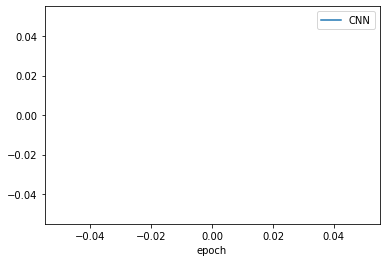

In [12]:
model = CNNmodel()
loss = nn.BCEWithLogitsLoss()
cnn_results = train_simple_network(model, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy_score}, device=device,epochs=10)

sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
print(cnn_results)
PATH = "CNNmodel.pt"
torch.save(model.state_dict(), PATH)

In [22]:
# print(predict_image())
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg"
img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (256, 256))
img = np.divide(img, 255)
img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
img=img.permute(1,3,2,0 )
img=Transform(img)
model=CNNmodel()
model.load_state_dict(torch.load(PATH))
model.eval()  
x=model(img)
x=x.detach().numpy()
print(x)

[1.6125421e-01 5.6209406e-05 1.7336854e-01 4.0363219e-01 1.6325857e-01
 7.8783482e-02 8.0417149e-06 1.4892442e-02 4.5759333e-03 1.7033918e-04]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [14]:
def get_model():  
    model = torchvision.models.resnet50()
    model.fc = nn.Linear(2048, 10, bias=True)
    return model

def get_model34():  
    model = torchvision.models.resnet34()
    model.fc = nn.Sequential(nn.Linear(512, 9, bias=True),
                             nn.Softmax())
#     output=torch.squeeze(output)
    return model

resnet50 = get_model()
resnet34 = get_model34()

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/1121 [00:00<?, ?it/s]

Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

Training:   0%|          | 0/1121 [00:00<?, ?it/s]

Testing:   0%|          | 0/1121 [00:00<?, ?it/s]

   epoch   total time  train loss  val loss  train Accuracy  val Accuracy
0      0  1036.696549    0.332261  0.318422             NaN           NaN
1      1  2070.836360    0.317148  0.316320             NaN           NaN


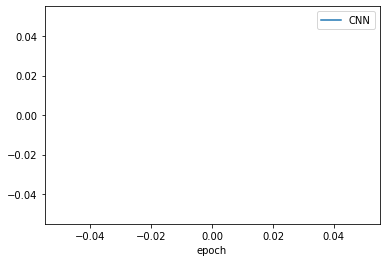

In [26]:
model = get_model()
loss = nn.BCEWithLogitsLoss()
cnn_results = train_simple_network(model, loss,train_loader, val_loader=train_loader,score_funcs={'Accuracy': accuracy_score}, device=device,epochs=2)

sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
print(cnn_results)
PATH = "Resenet50.pt"
torch.save(model.state_dict(), PATH)

In [30]:
device

device(type='cuda', index=0)

In [34]:
# print(predict_image())
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (256, 256))
img = np.divide(img, 255)
img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
img=img.permute(1,3,2,0 )
img=Transform(img)
img.to(device)
# model=CNNmodel()
# model.load_state_dict(torch.load(PATH))
model.eval()  
x=model(img.to(device))
# x=x.detach().numpy()
print(x)


tensor([[-2.4511, -2.8663, -1.6121, -1.9257, -2.1185, -1.7654, -2.7021, -1.6496,
         -2.2671, -3.1371]], device='cuda:0', grad_fn=<AddmmBackward>)


In [15]:
train.head(20)

,image_id,r_mean,g_mean,b_mean,cell_id,Label,size1,size2,ID
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5
5,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.040529,0.008827,0.062398,6,0,472,476,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_6
6,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.061733,0.026504,0.071511,7,0,428,555,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_7
7,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.040644,0.010379,0.047766,8,0,578,640,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_8
8,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0.074895,0.037825,0.112530,1,0,270,313,6166673c-bbad-11e8-b2ba-ac1f6b6435d0_1
9,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0.036115,0.012050,0.106811,2,0,408,208,6166673c-bbad-11e8-b2ba-ac1f6b6435d0_2


In [17]:
# print(predict_image())
full_filename=r"../input/hpa-cell-tiles-sample-balanced-dataset/cells/0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = cv2.imread(full_filename, cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (256, 256))
img = np.divide(img, 255)
img=torch.tensor(img,dtype=torch.float32).unsqueeze(1)
img=img.permute(1,3,2,0 )
img=Transform(img)
img.to(device)
model=get_model()
model.load_state_dict(torch.load('./Resenet50.pt'))
model.eval()  
x=model(img.to(device))
# x=x.detach().numpy()
print(x)


FileNotFoundError: [Errno 2] No such file or directory: './Resenet50.pt'